## LandCoverNet Model Training

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

This portion of the tutorial is focused on developing a semantic segmentation model for LandCoverNet data
Here:

1. We will load the prepared data as training, test and validation data

4. We will build a segmentation model, train it on the training data, inspect the results on the validation data and make predictions on the test data

In [1]:
import numpy as np
import pandas as pd

import contextlib
import warnings

from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, Conv2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

2022-02-22 10:45:16.942147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tmp_dir = "/home/jovyan/PlanetaryComputerExamples"
with open (f'{tmp_dir}/landcovnet/items.pkl', 'rb') as fp:
    Xys = pickle.load(fp)

In [3]:
temp=[]
for i in range (0, len(Xys)):
    temp.append(Xys[i][0].data)
temp = [it for sub in temp for it in sub]
temp = np.asarray(temp)
temp = temp.swapaxes(1,2)
temp = temp.swapaxes(2,3)
X=temp

In [7]:
X.shape

(7892, 256, 256, 3)

In [4]:
total=0
total_list=[]
for i in range(0,len(Xys)):
    total+=len(Xys[i][0])
    total_list.append(total)
Y= np.zeros((total, 256, 256), dtype=np.float32)
i=0
for j in range(0, len(total_list)):
    Y[i:total_list[j]]=Xys[j][1][0].data
    i=total_list[j]
    
del Xys
del temp
del total_list

In [5]:
X=np.array(X)
Y=np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
del X
del Y

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(5524, 256, 256, 3)
(5524, 256, 256)
(1184, 256, 256, 3)
(1184, 256, 256)
(1184, 256, 256, 3)
(1184, 256, 256)


### Building the model

We will make use of semantic segmentation using U-Net.

This model was thanks to YOUCEF GUICHI on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc)


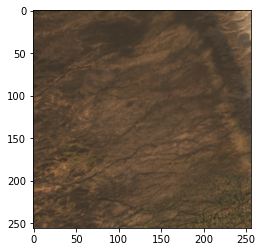

In [20]:
plt.imshow(x_train[107])

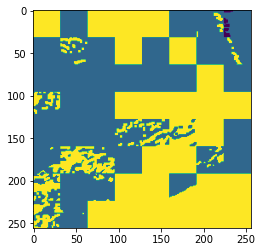

In [18]:
plt.imshow(y_train[107])

In [6]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [7]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [8]:
# using ResNet as model backbone with imagenet pretrained weights
Backbone = 'vgg19'

In [9]:
model = sm.Unet(backbone_name=Backbone, input_shape=(256, 256, 3), classes = 8, activation = 'sigmoid')

2022-02-22 10:28:07.498594: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-22 10:28:07.503651: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-22 10:28:07.601734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-22 10:28:07.601788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-22 10:28:07.719057: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-22 10:28:07.719214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-02-22 10

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model_checkpoint = ModelCheckpoint(tmp_dir+'/landcovnet/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [12]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=32, epochs=200, callbacks=[model_checkpoint])

2022-02-22 10:49:16.467041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4344250368 exceeds 10% of free system memory.
2022-02-22 10:49:17.196419: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1448083456 exceeds 10% of free system memory.
2022-02-22 10:49:17.710276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-22 10:49:17.727331: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2445410000 Hz


Epoch 1/200


2022-02-22 10:49:18.942745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-22 10:49:21.519045: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-22 10:49:21.656077: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-22 10:49:23.176947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


173/173 [==============================] - 350s 1s/step - loss: 1.5066 - accuracy: 0.3554 - val_loss: 1.5006 - val_accuracy: 0.3578

Epoch 00001: val_loss improved from inf to 1.50056, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 2/200
173/173 [==============================] - 147s 848ms/step - loss: 1.5041 - accuracy: 0.3512 - val_loss: 1.4968 - val_accuracy: 0.3572

Epoch 00002: val_loss improved from 1.50056 to 1.49677, saving model to /home/jovyan/PlanetaryComputerExamples/landcovnet/unet_model.hdf5
Epoch 3/200
173/173 [==============================] - 147s 849ms/step - loss: 1.4922 - accuracy: 0.3593 - val_loss: 1.4972 - val_accuracy: 0.3578

Epoch 00003: val_loss did not improve from 1.49677
Epoch 4/200
173/173 [==============================] - 147s 849ms/step - loss: 1.4869 - accuracy: 0.3605 - val_loss: 1.4981 - val_accuracy: 0.3572

Epoch 00004: val_loss did not improve from 1.49677
Epoch 5/200
173/173 [============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



173/173 [==============================] - 146s 845ms/step - loss: 1.5003 - accuracy: 0.3583 - val_loss: 1.6674 - val_accuracy: 0.3579

Epoch 00147: val_loss did not improve from 1.49552
Epoch 148/200
173/173 [==============================] - 146s 845ms/step - loss: 1.4916 - accuracy: 0.3524 - val_loss: 1.7591 - val_accuracy: 0.3579

Epoch 00148: val_loss did not improve from 1.49552
Epoch 149/200
173/173 [==============================] - 146s 845ms/step - loss: 1.4976 - accuracy: 0.3547 - val_loss: 1.4964 - val_accuracy: 0.3579

Epoch 00149: val_loss did not improve from 1.49552
Epoch 150/200
173/173 [==============================] - 146s 845ms/step - loss: 1.5057 - accuracy: 0.3489 - val_loss: 1.4957 - val_accuracy: 0.3579

Epoch 00150: val_loss did not improve from 1.49552
Epoch 151/200
173/173 [==============================] - 146s 845ms/step - loss: 1.4948 - accuracy: 0.3614 - val_loss: 1.4960 - val_accuracy: 0.3579

Epoch 00151: val_loss did not improve from 1.49552
Epoch 152

KeyboardInterrupt: 

### 

In [13]:
model.save(tmp_dir+'/landcovnet/model.hdf5')

In [14]:
# model = tf.keras.models.load_model(tmp_dir+'/landcovnet/unet_model.hdf5')

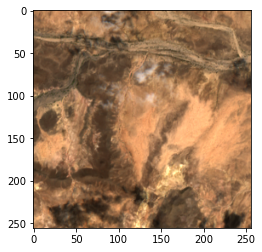

In [27]:
plt.imshow(x_train[100])

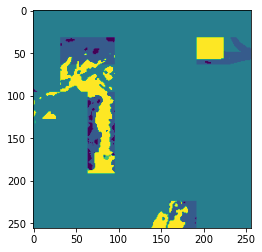

In [34]:
plt.imshow(y_train[100])

In [29]:
pred_mask = model.predict(np.expand_dims(x_train[100], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]

In [31]:
print(np.unique(pred_mask[0]))
print(np.unique(y_train[100]))

[7]
[0. 2. 3. 5. 7.]


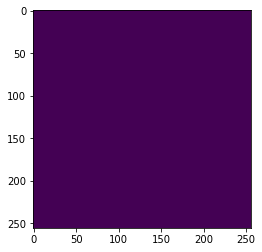

In [32]:
plt.imshow(pred_mask)

In [10]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [11]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=8):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [13]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [15]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Helper Functions During Model Training

ZAKIR ZEYNALOV on Kaggle for the same Aerial Semantic Segmentation Drone Dataset, made some useful helper functions below which can be used in conjuction with training.
Their implementation can be found [here](https://www.kaggle.com/menhior/aerial-drone-shots-image-segmentation)

They can be included in `unet.fit` for the callback parameter as shown in the comments for the code at the model training stage.

Since we were running across 100 epochs, they weren't included to make the output simple, although this applies particularly to `DisplayCallback()`. `ModelCheckpoint` and `EarlyStopping` can still be included for saving the model at the epoch with the best result and interrupting training when there's no improvement in results respectively (in our case, we chose 50 epochs).

In [15]:
#for displaying results after an epoch
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [16]:
#for items to be displayed
def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

In [17]:
def create_mask(pred_mask): #the results
    pred_mask = tf.where(pred_mask > 0.5,1,0)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [18]:
def show_predictions(x_train = x_train, y_train = y_train, num=1):
    #try:
    pred_mask = model.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])

In [19]:
display_cb = DisplayCallback()

In [17]:
model_checkpoint = ModelCheckpoint(tmp_dir+'/landcovnet/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)
[model_checkpoint]

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [23]:
import random #random displayed item
train_id = random.randint(0, len(x_train)-1)
train_id

2536

In [25]:
pred_mask = unet.predict(np.expand_dims(x_train[train_id], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]

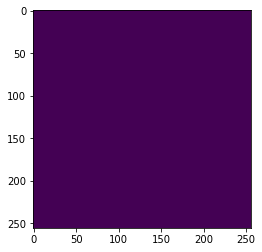

In [26]:
plt.imshow(pred_mask)